In [ ]:
!pip install fancyimpute

In [ ]:
import optuna
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from fancyimpute import SoftImpute

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [4]:

data_path = '/kaggle/input/nk-iv-prediction'
output_path = '/kaggle/working'
temp_path = '/kaggle/temp'

In [5]:

train_df = pd.read_parquet(f'{data_path}/train_data.parquet')
test_df = pd.read_parquet(f'{data_path}/test_data.parquet')
sample_df = pd.read_csv(f'{data_path}/sample_submission.csv')


In [6]:

iv_cols = [col for col in sample_df.columns if col.startswith("call_iv_") or col.startswith("put_iv_")]

# Normalize IV matrix
data_matrix = test_df[iv_cols].copy()
scaler = MinMaxScaler(feature_range=(0, 1))
data_norm = scaler.fit_transform(data_matrix.fillna(0))
mask = ~data_matrix.isna().values


In [ ]:
# Dataset with masking noise
class IVMatrixDataset(Dataset):
    def __init__(self, data, mask):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.mask = torch.tensor(mask, dtype=torch.float32)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        x = self.data[idx].clone()
        m = self.mask[idx]
        noise = (torch.rand_like(x) < 0.2) & m.bool()
        x[noise] = 0
        return x, self.data[idx], m

In [ ]:
# Define weighted MSE loss function
def weighted_mse_loss(pred, target, mask):
    # Create weights that emphasize at-the-money options
    n_strikes = pred.shape[1] // 2  # Half for calls, half for puts
    
    # Create weights centered around ATM (middle strikes)
    atm_idx = n_strikes // 2
    strike_weights = 1.0 / (1.0 + 0.2 * torch.abs(torch.arange(n_strikes, device=pred.device) - atm_idx))
    
    # Duplicate weights for both calls and puts
    weights = torch.cat([strike_weights, strike_weights], dim=0)
    
    # Apply weights to the squared error (only on known values)
    squared_error = ((pred - target) * mask) ** 2
    
    # Apply strike weights to each column
    weighted_error = squared_error * weights.view(1, -1)
    
    # Normalize by the sum of masks to get mean error only on observed values
    return torch.sum(weighted_error) / torch.sum(mask)

In [ ]:
class TunableCNN(nn.Module):
    def __init__(self, n_features, config):
        super().__init__()
        # Split features into calls and puts
        self.n_features = n_features
        self.n_strikes = n_features // 2  # Assuming equal call/put count
        
        # Get hyperparameters from config
        self.encoder_filters = config['encoder_filters']
        self.kernel_size = config['kernel_size']
        self.latent_dim = config['latent_dim']
        self.dropout_rate = config['dropout_rate']
        
        # CNN Encoder layers
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=self.encoder_filters[0], 
                              kernel_size=self.kernel_size, padding=self.kernel_size//2)
        self.conv2 = nn.Conv1d(in_channels=self.encoder_filters[0], out_channels=self.encoder_filters[1], 
                              kernel_size=self.kernel_size, padding=self.kernel_size//2)
        
        # FC latent representation
        self.flatten = nn.Flatten()
        self.fc_latent = nn.Linear(self.encoder_filters[1] * self.n_strikes, self.latent_dim)
        
        # Decoder layers
        self.fc_decode = nn.Linear(self.latent_dim, 64)
        self.fc_reshape = nn.Linear(64, self.encoder_filters[0] * self.n_strikes)
        self.conv3 = nn.Conv1d(in_channels=self.encoder_filters[0], out_channels=2, 
                              kernel_size=self.kernel_size, padding=self.kernel_size//2)
        
        # Activations
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(self.dropout_rate)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        batch_size = x.shape[0]
        
        # Reshape to [batch, 2, strikes] - organizing calls and puts for CNN
        x_reshaped = x.view(batch_size, 2, self.n_strikes)
        
        # Encoder
        e1 = self.relu(self.conv1(x_reshaped))
        e1 = self.dropout(e1)
        e2 = self.relu(self.conv2(e1))
        e2 = self.dropout(e2)
        
        # Flatten and get latent representation
        flat = self.flatten(e2)
        z = self.relu(self.fc_latent(flat))
        
        # Decoder
        d1 = self.relu(self.fc_decode(z))
        d2 = self.relu(self.fc_reshape(d1))
        d2 = d2.view(batch_size, self.encoder_filters[0], self.n_strikes)
        
        # Skip connection from e1 (similar to U-Net style)
        d2 = d2 + e1
        
        # Final convolution to get output
        out = self.sigmoid(self.conv3(d2))
        
        # Reshape back to original format
        return out.view(batch_size, self.n_features)

In [ ]:
def objective(trial, data_norm, mask):
    # Define hyperparameter search space
    config = {
        'encoder_filters': [
            trial.suggest_int('filters1', 8, 32, step=8),
            trial.suggest_int('filters2', 16, 64, step=8)
        ],
        'kernel_size': trial.suggest_int('kernel_size', 3, 7, step=2),
        'latent_dim': trial.suggest_int('latent_dim', 16, 64, step=8),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.0, 0.5, step=0.1),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128])
    }
    
    # Create dataset
    dataset = IVMatrixDataset(data_norm, mask)
    dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)
    
    # Create validation set (10% of data)
    val_size = int(0.1 * len(dataset))
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
    
    # Initialize model
    model = TunableCNN(data_norm.shape[1], config).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    
    # Train for a small number of epochs to evaluate configuration
    n_epochs = 100
    best_val_loss = float('inf')
    patience = 20
    patience_counter = 0
    
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for x_noisy, x_true, m in train_loader:
            x_noisy = x_noisy.to(device)
            x_true = x_true.to(device)
            m = m.to(device)
            
            optimizer.zero_grad()
            pred = model(x_noisy)
            loss = weighted_mse_loss(pred, x_true, m)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_noisy, x_true, m in val_loader:
                x_noisy = x_noisy.to(device)
                x_true = x_true.to(device)
                m = m.to(device)
                
                pred = model(x_noisy)
                loss = weighted_mse_loss(pred, x_true, m)
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
        
        # Report intermediate metric to Optuna
        trial.report(val_loss, epoch)
        
        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return best_val_loss

In [12]:
def run_hyperparameter_tuning(data_norm, mask):
    study = optuna.create_study(direction="minimize", 
                               pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
    study.optimize(lambda trial: objective(trial, data_norm, mask), 
                  n_trials=20, timeout=3600)  # Run for 20 trials or 1 hour
    
    print("Best trial:")
    trial = study.best_trial
    
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    
    # Plot optimization history
    try:
        plt.figure(figsize=(12, 8))
        optuna.visualization.matplotlib.plot_optimization_history(study)
        plt.savefig('optuna_history.png')
        
        plt.figure(figsize=(12, 8))
        optuna.visualization.matplotlib.plot_param_importances(study)
        plt.savefig('optuna_importances.png')
    except:
        print("Error generating plots, but tuning completed successfully.")
    
    return study.best_params

In [ ]:
def train_optimized_model(data_norm, mask, best_params):
    # Prepare config from best params
    config = {
        'encoder_filters': [
            best_params['filters1'],
            best_params['filters2']
        ],
        'kernel_size': best_params['kernel_size'],
        'latent_dim': best_params['latent_dim'],
        'dropout_rate': best_params['dropout_rate'],
        'learning_rate': best_params['learning_rate'],
        'batch_size': best_params['batch_size']
    }
    
    print(f"Training optimized model with config: {config}")
    
    # Create dataset
    dataset = IVMatrixDataset(data_norm, mask)
    dataloader = DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)
    
    # Initialize model
    model = TunableCNN(data_norm.shape[1], config).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=100, 
        min_lr=1e-6
    )
    
    # Train the model with optimized hyperparameters (using same parameters as original training)
    best_loss = float('inf')
    patience = 200
    patience_counter = 0
    best_state_dict = None
    
    model.train()
    for epoch in range(3000):
        total_loss = 0
        for x_noisy, x_true, m in dataloader:
            x_noisy = x_noisy.to(device)
            x_true = x_true.to(device)
            m = m.to(device)
            
            optimizer.zero_grad()
            pred = model(x_noisy)
            loss = weighted_mse_loss(pred, x_true, m)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Calculate average loss for this epoch
        avg_loss = total_loss / len(dataloader)
        
        # Update learning rate based on loss
        prev_lr = optimizer.param_groups[0]['lr']
        scheduler.step(avg_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Early stopping check
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            # Save best model weights
            best_state_dict = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}, Loss: {avg_loss:.6f}, LR: {current_lr:.6e}")
    
    # Load best model for return
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
    
    return model

[I 2025-06-11 14:14:59,424] A new study created in memory with name: no-name-97ffc82e-d381-47de-960e-341de65560f7


Starting hyperparameter tuning...


[I 2025-06-11 14:17:37,862] Trial 0 finished with value: 0.0004639089341875852 and parameters: {'filters1': 24, 'filters2': 56, 'kernel_size': 3, 'latent_dim': 48, 'dropout_rate': 0.2, 'learning_rate': 0.0001952816414652214, 'batch_size': 32}. Best is trial 0 with value: 0.0004639089341875852.
[I 2025-06-11 14:21:25,939] Trial 1 finished with value: 9.673628320390555e-05 and parameters: {'filters1': 8, 'filters2': 56, 'kernel_size': 3, 'latent_dim': 40, 'dropout_rate': 0.1, 'learning_rate': 0.0023151817148202784, 'batch_size': 32}. Best is trial 1 with value: 9.673628320390555e-05.
[I 2025-06-11 14:24:15,752] Trial 2 finished with value: 0.00014487278090918583 and parameters: {'filters1': 16, 'filters2': 56, 'kernel_size': 5, 'latent_dim': 40, 'dropout_rate': 0.2, 'learning_rate': 0.00026612370127676956, 'batch_size': 32}. Best is trial 1 with value: 9.673628320390555e-05.
[I 2025-06-11 14:25:52,629] Trial 3 finished with value: 0.00041696252485149 and parameters: {'filters1': 8, 'filt

Best trial:
  Value: 1.5186529181894576e-05
  Params: 
    filters1: 16
    filters2: 48
    kernel_size: 5
    latent_dim: 56
    dropout_rate: 0.0
    learning_rate: 0.003519672678761618
    batch_size: 64


/tmp/ipykernel_13/766463772.py:18: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)
/tmp/ipykernel_13/766463772.py:22: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


Training optimized model with config: {'encoder_filters': [16, 48], 'kernel_size': 5, 'latent_dim': 56, 'dropout_rate': 0.0, 'learning_rate': 0.003519672678761618, 'batch_size': 64}
Epoch 50, Loss: 0.000026, LR: 3.519673e-03
Epoch 100, Loss: 0.000019, LR: 3.519673e-03
Epoch 150, Loss: 0.000015, LR: 3.519673e-03
Epoch 200, Loss: 0.000012, LR: 3.519673e-03
Epoch 250, Loss: 0.000011, LR: 3.519673e-03
Epoch 300, Loss: 0.000011, LR: 3.519673e-03
Epoch 350, Loss: 0.000010, LR: 3.519673e-03
Epoch 400, Loss: 0.000010, LR: 3.519673e-03
Epoch 450, Loss: 0.000008, LR: 1.759836e-03
Epoch 500, Loss: 0.000008, LR: 1.759836e-03
Epoch 550, Loss: 0.000008, LR: 1.759836e-03
Epoch 600, Loss: 0.000008, LR: 1.759836e-03
Epoch 650, Loss: 0.000008, LR: 1.759836e-03
Epoch 700, Loss: 0.000007, LR: 1.759836e-03
Epoch 750, Loss: 0.000008, LR: 1.759836e-03
Epoch 800, Loss: 0.000008, LR: 1.759836e-03
Epoch 850, Loss: 0.000007, LR: 8.799182e-04
Epoch 900, Loss: 0.000007, LR: 8.799182e-04
Epoch 950, Loss: 0.000007, 

/usr/local/lib/python3.11/dist-packages/fancyimpute/solver.py:55: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")


[SoftImpute] Iter 1: observed MAE=0.000052 rank=52
[SoftImpute] Iter 2: observed MAE=0.000052 rank=52
[SoftImpute] Iter 3: observed MAE=0.000052 rank=52
[SoftImpute] Iter 4: observed MAE=0.000052 rank=52
[SoftImpute] Iter 5: observed MAE=0.000052 rank=52
[SoftImpute] Iter 6: observed MAE=0.000052 rank=52
[SoftImpute] Iter 7: observed MAE=0.000052 rank=52
[SoftImpute] Iter 8: observed MAE=0.000052 rank=52
[SoftImpute] Iter 9: observed MAE=0.000052 rank=52
[SoftImpute] Iter 10: observed MAE=0.000052 rank=52
[SoftImpute] Iter 11: observed MAE=0.000052 rank=52
[SoftImpute] Iter 12: observed MAE=0.000052 rank=52
[SoftImpute] Iter 13: observed MAE=0.000052 rank=52
[SoftImpute] Iter 14: observed MAE=0.000052 rank=52
[SoftImpute] Iter 15: observed MAE=0.000052 rank=52
[SoftImpute] Iter 16: observed MAE=0.000052 rank=52
[SoftImpute] Iter 17: observed MAE=0.000052 rank=52
[SoftImpute] Iter 18: observed MAE=0.000052 rank=52
[SoftImpute] Iter 19: observed MAE=0.000052 rank=52
[SoftImpute] Iter 20:

<Figure size 1200x800 with 0 Axes>

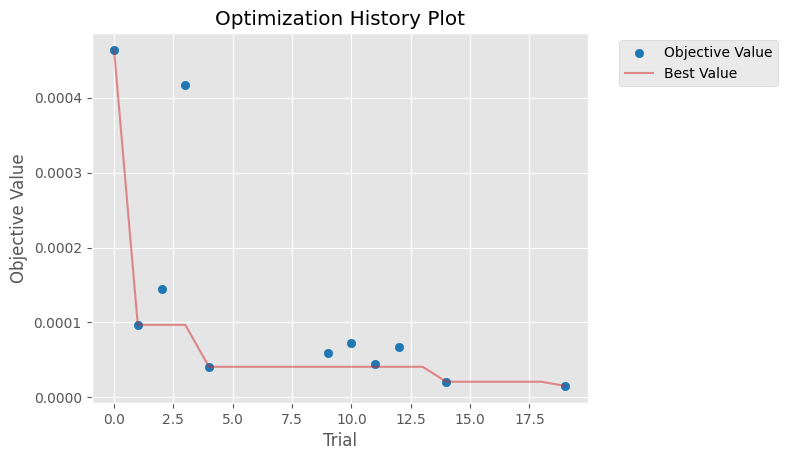

<Figure size 1200x800 with 0 Axes>

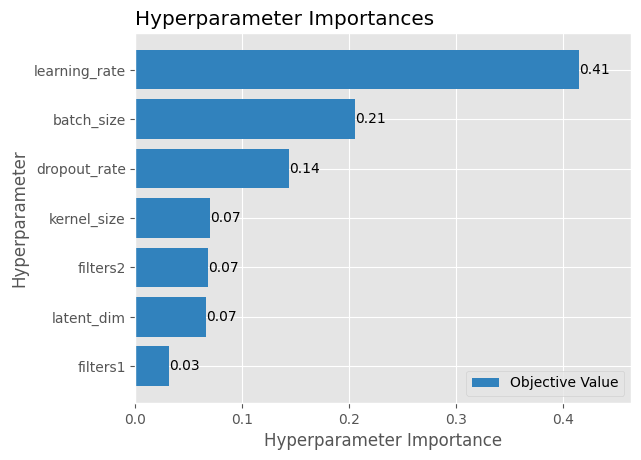

In [ ]:
# Run the hyperparameter tuning
print("Starting hyperparameter tuning...")
best_params = run_hyperparameter_tuning(data_norm, mask)

# Train the final model with the best hyperparameters
optimized_model = train_optimized_model(data_norm, mask, best_params)

# Save the optimized model
torch.save(optimized_model.state_dict(), "optimized_cnn_ae.pt")

# Generate predictions using the optimized model
optimized_model.eval()
with torch.no_grad():
    # Process in batches to prevent memory issues
    batch_size = 128
    cnn_preds = np.zeros_like(data_norm)
    
    for i in range(0, data_norm.shape[0], batch_size):
        end_idx = min(i + batch_size, data_norm.shape[0])
        batch_data = torch.tensor(data_norm[i:end_idx], dtype=torch.float32).to(device)
        preds = optimized_model(batch_data).cpu().numpy()
        cnn_preds[i:end_idx] = preds
    
    # Save predictions
    np.save('optimized_cnn_ae_preds.npy', cnn_preds)
    
    # Apply the same residual correction as before
    residuals = np.zeros_like(data_norm)
    residuals[mask] = data_norm[mask] - cnn_preds[mask]
    
    print("Applying SoftImpute to residuals...")
    residual_imputed = SoftImpute(max_iters=100, init_fill_method="zero").fit_transform(residuals)
    
    # Apply residual correction only to missing values
    cnn_preds[~mask] += residual_imputed[~mask]
    
    # Final predictions
    optimized_imputed_rescaled = scaler.inverse_transform(cnn_preds)

# Create final submission DataFrame with optimized model results
optimized_df = pd.DataFrame(optimized_imputed_rescaled, columns=iv_cols)
optimized_df.insert(0, "timestamp", sample_df["timestamp"])
for col in iv_cols:
    optimized_df[col] = np.clip(optimized_df[col], 0.01, 1.5)
optimized_df.to_csv("submission.csv", index=False)
print(f"Optimized model submission saved to submission.csv")

# Compare original and optimized models